# Using Neural Networks To Solve The Problem

The below code has been adapted from [this article](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/) on text generation with LSTM and [this article](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17) on classification with LSTM.

In [ ]:
#Let's suppress the matplotlib deprecation warning here
import warnings
warnings.filterwarnings("ignore")

# Gotta bring some mates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.callbacks import EarlyStopping

import re
from spacy.lang.en.stop_words import STOP_WORDS
import spacy

from sklearn.model_selection import train_test_split

In [ ]:
nlp = spacy.load("en_core_web_lg")

In [3]:
df = pd.read_csv('../data/bechdel_script_df.csv')
df.head()

,Unnamed: 0,title,script,simple_bechdel,women,men
0,0,warrior,WARRIOR ...,0,13,43
1,1,collateral,COLLA...,0,8,30
2,6,gamer,GAMER ...,0,24,38
3,7,wanted,WANTED ...,0,7,17
4,8,2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by...,0,9,19


In [4]:
df.drop(columns=['Unnamed: 0', 'women', 'men'], axis=1, inplace=True)

In [5]:
df.head()

,title,script,simple_bechdel
0,warrior,WARRIOR ...,0
1,collateral,COLLA...,0
2,gamer,GAMER ...,0
3,wanted,WANTED ...,0
4,2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by...,0


In [6]:
df.shape

(464, 3)

In [7]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
STOPWORDS |= {'ve', 'int', 'ext', 'just', 'don', 'know', 'like', 'day', 'continued', 'got', 'away', 'looks', 'cont',
                    'door', 'll', 'night', 'room', 'right', 'look', 'www', 'pdf', 'little', 'house', 'eyes', 'face',
                    'screentalk', 'later', 'revs', '03', '10', '12', '21', 'draft', 'screening', 'script', 'revised', 'screenplay'}

def clean_script(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['script'] = df['script'].apply(clean_script)
df['script'] = df['script'].str.replace('\d+', '')


### A quick check on the output

In [8]:
df['script'][42]

'coriolanus written william shakespeare john logan darkened blade knife pulled sheath intricate tribal etchings blade catching light blade pulled sharpening stone swoosh swooshswoosh rhythmic wellpracticed hand muscular tattooed arm blade held razor sharp glow tv darkened illumination images tv global urban strife slums barricades poverty starvation demonstrations repression refugee camps barbed wire prisons riot police tear gas violence images settle breaking news food riots rome images protest march crowd filling streets soldiers moving position placards dogs eat meat mouths man sharpening knife watches images cold disinterested stops frozen midstroke tv suddenly rivets longer cold tv shows soldiers highranking officer imperious giving orders come man caius martius coriolanus tullus aufidius man sharpening knife gazes image screen leans forward emerging darkness handsome imposing figure magnetic personality charismatic yes neurotic edgy uncomfortable skin demons watches caius martius

In [9]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['script'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 144343 unique tokens.


In [10]:
total_vocab = len(word_index) + 1

In [11]:
X = tokenizer.texts_to_sequences(df['script'].values)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (464, 25394)


In [12]:
Y = df['simple_bechdel'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (464,)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(f'X_train is: {X_train.shape} and Y_train is: {Y_train.shape}')
print(f'X_test is: {X_test.shape} and Y_test is: {Y_test.shape}')

X_train is: (348, 25394) and Y_train is: (348,)
X_test is: (116, 25394) and Y_test is: (116,)


### Fitting and running the LSTM Model

I started out following the exact instructions of the article from Susan Li before tinkering with the model to work on the overall results, with a simple tweak for it to be for binary classification instead of multi-class.

I set the first part of the Embedding layer to the total number of tokens found in the dataframe (+1). If this takes too long I will go back and choose a maximum number for this as this might be too computationally expensive otherwise.

In [14]:
X.shape[1]

25394

In [15]:
model = Sequential()
model.add(Embedding(total_vocab, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2)) #for variational dropout

model.add(LSTM(128, input_shape=(X.shape[1],))) #erroring here now
model.add(Dropout(0.2))


model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 128



In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5


### Saving Models

I will be saving each model, rather than pickling them, as recommended by Jason Brownlee in [this article](https://machinelearningmastery.com/save-load-keras-deep-learning-models/).

In [73]:
model.save('../assets/model_4.h5')
print('Saved model to assets folder. Please remember to change number above before saving next model.')

Saved model to assets folder. Please remember to change number above before saving next model.


### Plotting the Models

Below we can see how our models perform across the epochs.

Information from each iteration:

1. loss: 0.4668 - accuracy: 0.9179 - val_loss: 0.6894 - val_accuracy: 0.6000

The first model that was run was incredibly overfit. We are going to need to work on this some more.

2. loss: 0.6024 - accuracy: 0.5039 - val_loss: 0.7552 - val_accuracy: 0.5698

The second model included a validation of .25 and 6 epochs.

3. loss: 0.1155 - accuracy: 0.9813 - val_loss: 0.7270 - val_accuracy: 0.5362

The third model ran included a validation of .2 and ran for 9 epochs.

4. loss: 0.5117 - accuracy: 0.9495 - val_loss: 0.6869 - val_accuracy: 0.5833

The fourth model ran included a validation of .1 and ran for 5 epochs. It was trained on a slightly larger corpus of 468 observations.

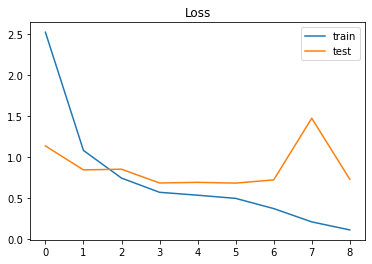

In [57]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

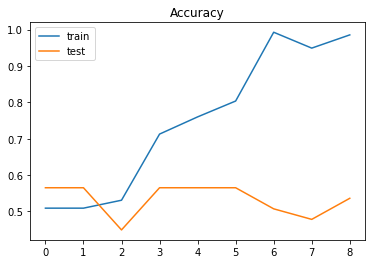

In [58]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();